# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor
from collections import deque
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
env = UnityEnvironment(file_name="/codebase/deep-reinforcement-learning-v2/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# define logger
log_path = os.getcwd()+"/log"
logger = SummaryWriter(log_dir=log_path)

In [5]:
def main_maddpg():
    seeding()
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    
    #env = UnityEnvironment(file_name="/codebase/deep-reinforcement-learning-v2/p3_collab-compet/Tennis_Linux/Tennis.x86_64")
    # get the default brain
    #brain_name = env.brain_names[0]
    #brain = env.brains[brain_name]


    number_of_episode = 20000
    episode_length = 1000
    batchsize = 256
    # how many episodes to save policy and gif
    save_interval = 1000
    rewards_deque = deque(maxlen=100)
    rewards = []
    scores = []
    save_dict_list = []
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 1.0
    noise_reduction = 1.0 #0.9999
    BUFFER_SIZE = int(1e5) # replay buffer size
    
    print_every = 100
    # how many episodes before update

    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    num_agents, num_spaces = states.shape
        
    #log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)
    
    buffer = ReplayBuffer(BUFFER_SIZE)
    
    # initialize policy and critic
    maddpg = MADDPG(num_agents, num_spaces)
    #logger = SummaryWriter(log_dir=log_path)

    # training loop
    # show progressbar
    """
    import progressbar as pb
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()
    """

    # use keep_awake to keep workspace from disconnecting
    for episode in range(0, number_of_episode):
        rewards_this_episode = np.zeros((num_agents, ))
        #timer.update(episode)

        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations        
        reward_this_episode = np.zeros((num_agents, ))
    
        
        for episode_t in range(episode_length):          
            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            actions = maddpg.act(states, noise=noise)
            noise *= noise_reduction
            
            #actions_array = torch.stack(actions).detach().numpy()

            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            #actions_for_env = np.rollaxis(actions_array,1)
            
            # step forward one frame
            #next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            #print('main-transition-next_states: ', next_states)
            # add data to buffer
            transition = (states, actions, rewards, next_states, dones)
            buffer.push(transition)
            
            stats = next_states
            reward_this_episode += rewards
            
            if np.any(dones):
                break

        # update once after every episode_per_update
        if len(buffer) > batchsize:
            for _ in range(5):
                for a_i in range(num_agents):
                    samples = buffer.sample(batchsize)

                    maddpg.update(samples, a_i, logger)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        rewards.append(reward_this_episode)
        # just get maximum rewards
        rewards_deque.append(np.max(rewards_this_episode))
        average_score = np.mean(rewards_deque)

        scores.append(average_score)
        #saving model
        #save_dict_list =[]
        
        if episode_t % print_every == 0 or average_score > 0.5:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(episode, average_score), end="")
                        
            if average_score > 0.5:
                for i in range(num_agents):
                    save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                                 'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                                 'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                                 'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                    save_dict_list.append(save_dict)

                    torch.save(save_dict_list, 
                               os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                break
    return scores
    

In [6]:
scores = main_maddpg()


Episode 129	Average Score: 0.00
Episode 322	Average Score: 0.00
Episode 437	Average Score: 0.00
Episode 594	Average Score: 0.00
Episode 692	Average Score: 0.00
Episode 793	Average Score: 0.00
Episode 929	Average Score: 0.00
Episode 1067	Average Score: 0.00
Episode 1158	Average Score: 0.00
Episode 1258	Average Score: 0.00
Episode 1357	Average Score: 0.00
Episode 1455	Average Score: 0.00
Episode 1626	Average Score: 0.00
Episode 1723	Average Score: 0.00
Episode 1821	Average Score: 0.00

Text(0.5, 0, 'Episode #')

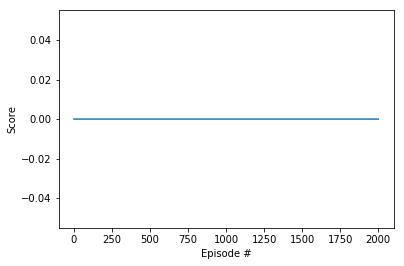

In [7]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')


In [8]:
env.close()
logger.close()
#timer.finish()

When finished, you can close the environment.